In [8]:
import jax
from jax import numpy as jnp
from flax import linen as nn
from typing import Tuple, Callable
import numpy as np
from netket.utils.types import NNInitFunc, DType
from jax.nn.initializers import (
    zeros,
    ones,
    lecun_normal,
    normal
)

from distances import dist_min_image
from deepset_script import deepset
import netket as nk
import matplotlib.pyplot as plt
import pandas as pd
import json
from matplotlib.ticker import FormatStrFormatter

PI = jnp.pi

ImportError: DLL load failed while importing _igraph: The specified module could not be found.

In [2]:
def dist_min_image(x, L, sdim):

    #computes distances following minimum image convention
    
    n_particles = x.shape[0]//sdim
    x = x.reshape(-1, sdim)

    distances = (-x[jnp.newaxis, :, :] + x[:, jnp.newaxis, :])[
    jnp.triu_indices(n_particles, 1)]

    distances = jnp.remainder(distances + L / 2.0, L) - L / 2.0
    return  jnp.linalg.norm(distances, axis=-1)

In [12]:
x = jnp.array([[1,0],[0,2.]]).reshape(1,-1)
print(x.shape)
print(dist_min_image(x[0], 100, 1))

(1, 4)
[1. 1. 1. 0. 2. 2.]


In [3]:
def V(x, sdim, L, eps, sigma):
    #vector of distances

    norm = dist_min_image(x, L, sdim, norm = True)
    #distances = jnp.array([[jnp.linalg.norm(jnp.sin(PI*(x_i-x_j)/L)) for x_i in x] for x_j in x])
 
    #terms to be summed in the potential
    arg = jnp.exp(-norm**2/(2*sigma**2))
                                                                        
    pot = eps*jnp.sum(arg)

    return pot

Text(0, 0.5, '$V(r)$')

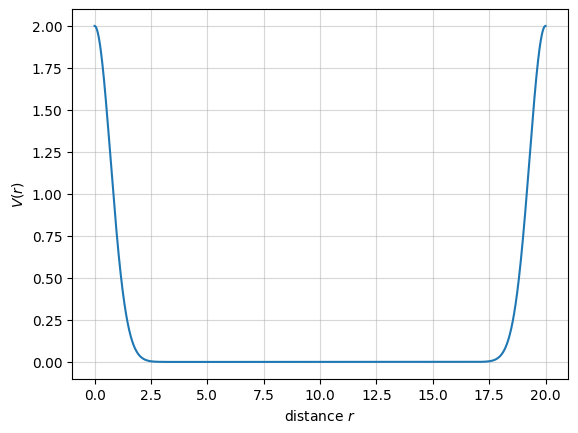

In [21]:
x = jnp.arange(0,L,0.001)
y = jnp.zeros_like(x)
xnew = jnp.vstack((y, x)).T

test = jax.vmap(V, in_axes = (0, None, None, None, None))(xnew, sdim, L, eps, sigma)
fig, ax = plt.subplots()
ax.plot(x,test)
ax.grid(alpha=0.5)
ax.set_xlabel(r"distance $r$")
ax.set_ylabel(r"$V(r)$")


In [4]:
def mycb(step, logged_data, driver):
    logged_data["acceptance"] = float(driver.state.sampler_state.acceptance)
    return True

In [7]:
L = 20
sigma = 2**-.5
sdim = 1
eps = 2

v = lambda x: V(x,sdim,L,eps,sigma)

hilb = nk.hilbert.Particle(N=20, L=(L,), pbc=True)

sab = nk.sampler.MetropolisGaussian(hilb, sigma=0.4, n_chains=16, n_sweeps=32)

ekin = nk.operator.KineticEnergy(hilb, mass=1.0)
pot = nk.operator.PotentialEnergy(hilb, v)
ha = ekin + pot

model = deepset(layers_phi=2, layers_rho=2, width_phi=(5,5), width_rho=(5,1), sdim=sdim, L=L)

vs = nk.vqs.MCState(sab, model, n_samples=5*10**3, n_discard_per_chain=100)
op = nk.optimizer.Sgd(0.05)
sr = nk.optimizer.SR(diag_shift=0.01)

gs = nk.VMC(ha, op, sab, variational_state=vs, preconditioner=sr)
gs.run(n_iter=1000, callback=mycb, out="int_bosons_1d")

  1%|▏         | 14/1000 [00:20<24:29,  1.49s/it, Energy=33.74 ± 0.13 [σ²=42.82, R̂=1.0034]]


KeyboardInterrupt: 

In [4]:
import json

data = json.load(open('int_bosons_1d_colab_lr=1e-2_sigma=0.1.log', 'rb'))

energy = jnp.array(data['Energy']['Mean'])
sigma = jnp.array(data['Energy']['Sigma'])
acceptance = jnp.array(data['acceptance']['value'])

In [5]:
window_size = 10
mov_avg = []
mov_std = []
for i in range(len(energy) - window_size + 1):
    
    # Store elements from i to i+window_size
    # in list to get the current window
    window = energy[i : i + window_size]
  
    # Calculate the average of current window
    window_average = jnp.mean(window)
    window_std = jnp.std(window)
      
    # Store the average of current
    # window in moving average list
    mov_avg.append(window_average)
    mov_std.append(window_std)

mov_avg = jnp.array(mov_avg)
mov_std = jnp.array(mov_std)

In [9]:
import matplotlib.pyplot as plt

'\naxins = ax.inset_axes([0.25, 0.5, 0.7, 0.2])\n\naxins.plot(jnp.arange(len(mov_avg)), mov_avg, color=\'C0\')\naxins.fill_between(jnp.arange(len(mov_avg)), mov_avg - mov_std, mov_avg + mov_std, color=\'C0\', alpha=0.2)\n\naxins.plot(jnp.arange(len(mov_avg_NK)), mov_avg_NK, color=\'C1\', label=\'NetKet\')\naxins.fill_between(jnp.arange(len(mov_avg_NK)), mov_avg_NK - mov_std_NK, mov_avg_NK + mov_std_NK, color=\'C1\', alpha=0.2)\n\naxins.axhline(15, linestyle=\'--\', color=\'C2\')\nx1, x2, y1, y2 = 450, 950, 15-0.5, 15+0.5\naxins.set_xlim(x1, x2)\naxins.set_ylim(y1, y2)\naxins.set_yticks([14.7, 15.0, 15.3])\naxins.set_xticks([500,700,900])\naxins.yaxis.set_major_formatter(FormatStrFormatter(\'%.2f\'))\naxins.grid(alpha=0.5)\nax.indicate_inset_zoom(axins, edgecolor="black")\n'

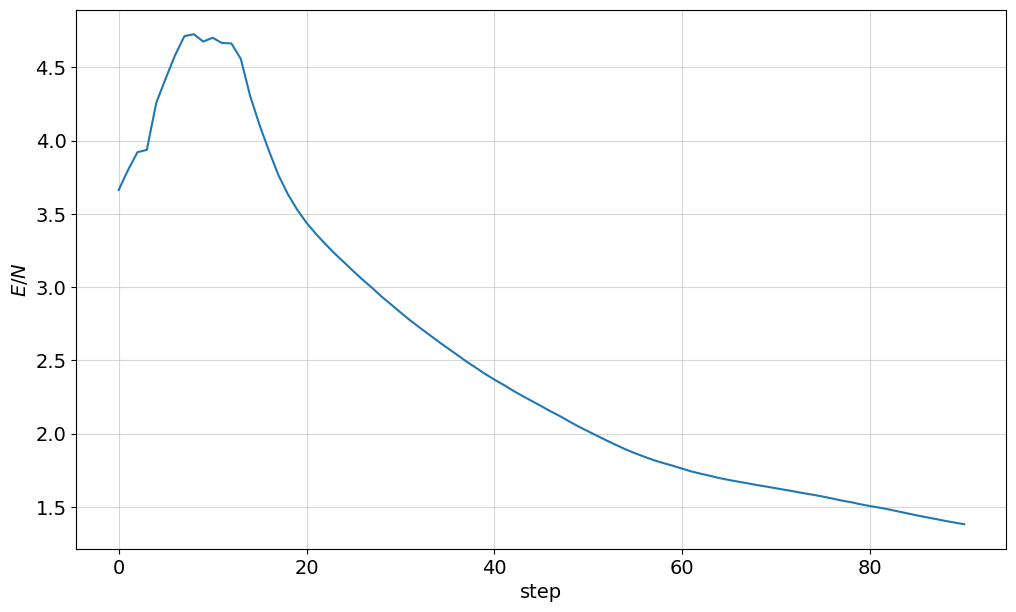

In [10]:
N=20
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(figsize=(12,7))

ax.plot(jnp.arange(len(mov_avg)), mov_avg/N, color='C0')#, label='own implementation')
#ax.fill_between(jnp.arange(len(mov_avg)), (mov_avg - mov_std)/N, (mov_avg + mov_std)/N, color='C0', alpha=0.2)

#ax.axhline(15, linestyle='--', color='C2', label= r'exact $N=10$')

ax.set_xlabel('step')
ax.set_ylabel(r'$E/N$')
ax.grid(alpha=0.5)
#ax.legend(loc='best', ncols=2)

'''
axins = ax.inset_axes([0.25, 0.5, 0.7, 0.2])

axins.plot(jnp.arange(len(mov_avg)), mov_avg, color='C0')
axins.fill_between(jnp.arange(len(mov_avg)), mov_avg - mov_std, mov_avg + mov_std, color='C0', alpha=0.2)

axins.plot(jnp.arange(len(mov_avg_NK)), mov_avg_NK, color='C1', label='NetKet')
axins.fill_between(jnp.arange(len(mov_avg_NK)), mov_avg_NK - mov_std_NK, mov_avg_NK + mov_std_NK, color='C1', alpha=0.2)

axins.axhline(15, linestyle='--', color='C2')
x1, x2, y1, y2 = 450, 950, 15-0.5, 15+0.5
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
axins.set_yticks([14.7, 15.0, 15.3])
axins.set_xticks([500,700,900])
axins.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
axins.grid(alpha=0.5)
ax.indicate_inset_zoom(axins, edgecolor="black")
'''

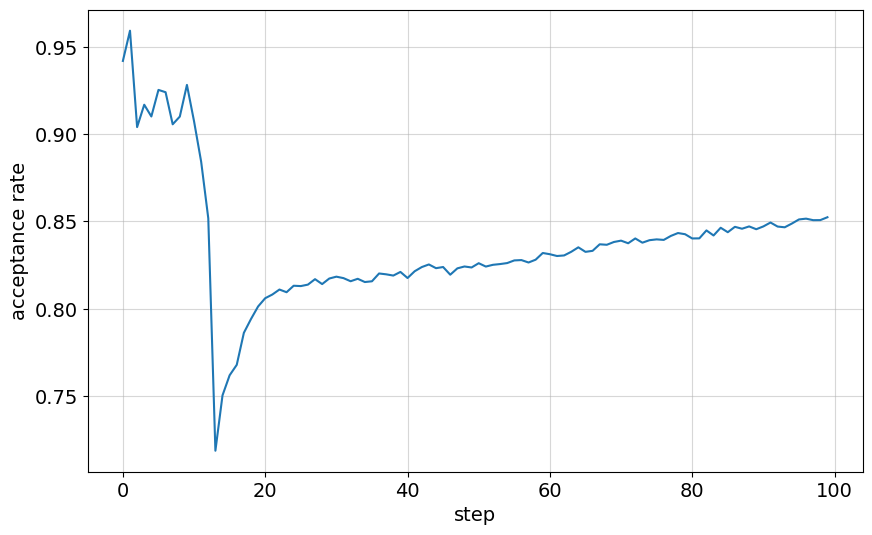

In [11]:
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(figsize=(10,6))

ax.plot(jnp.arange(len(acceptance)), acceptance)
ax.set_xlabel('step')
ax.set_ylabel('acceptance rate')
ax.grid(alpha=0.5)

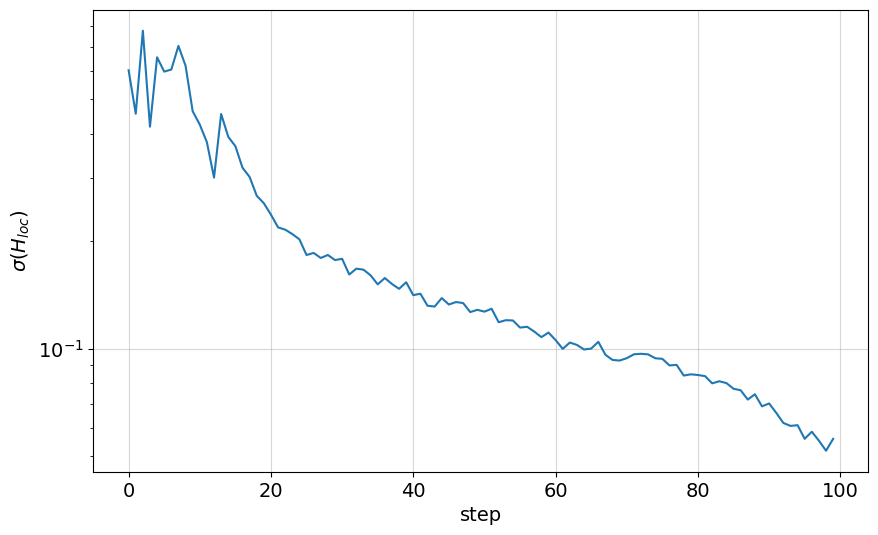

In [12]:
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(figsize=(10,6))

ax.plot(jnp.arange(len(sigma)), sigma)
ax.set_xlabel('step')
ax.set_ylabel(r'$\sigma(H_{loc})$')
ax.set_yscale('log')
ax.grid(alpha=0.5)